## Vertex AI Pipeline Overview
Vertex AI Pipelines helps you to automate, monitor, and govern your ML systems by orchestrating your ML workflow in a serverless manner, and storing your workflow's artifacts using Vertex ML Metadata. By storing the artifacts of your ML workflow in Vertex ML Metadata, you can analyze the lineage of your workflow's artifacts — for example, an ML model's lineage may include the training data, hyperparameters, and code that were used to create the model.

## Solution Architecture

This pipeline will evaluate the custom built model with the models buit using AutoML and BQML. The pipeline deploys the model with best accuracy

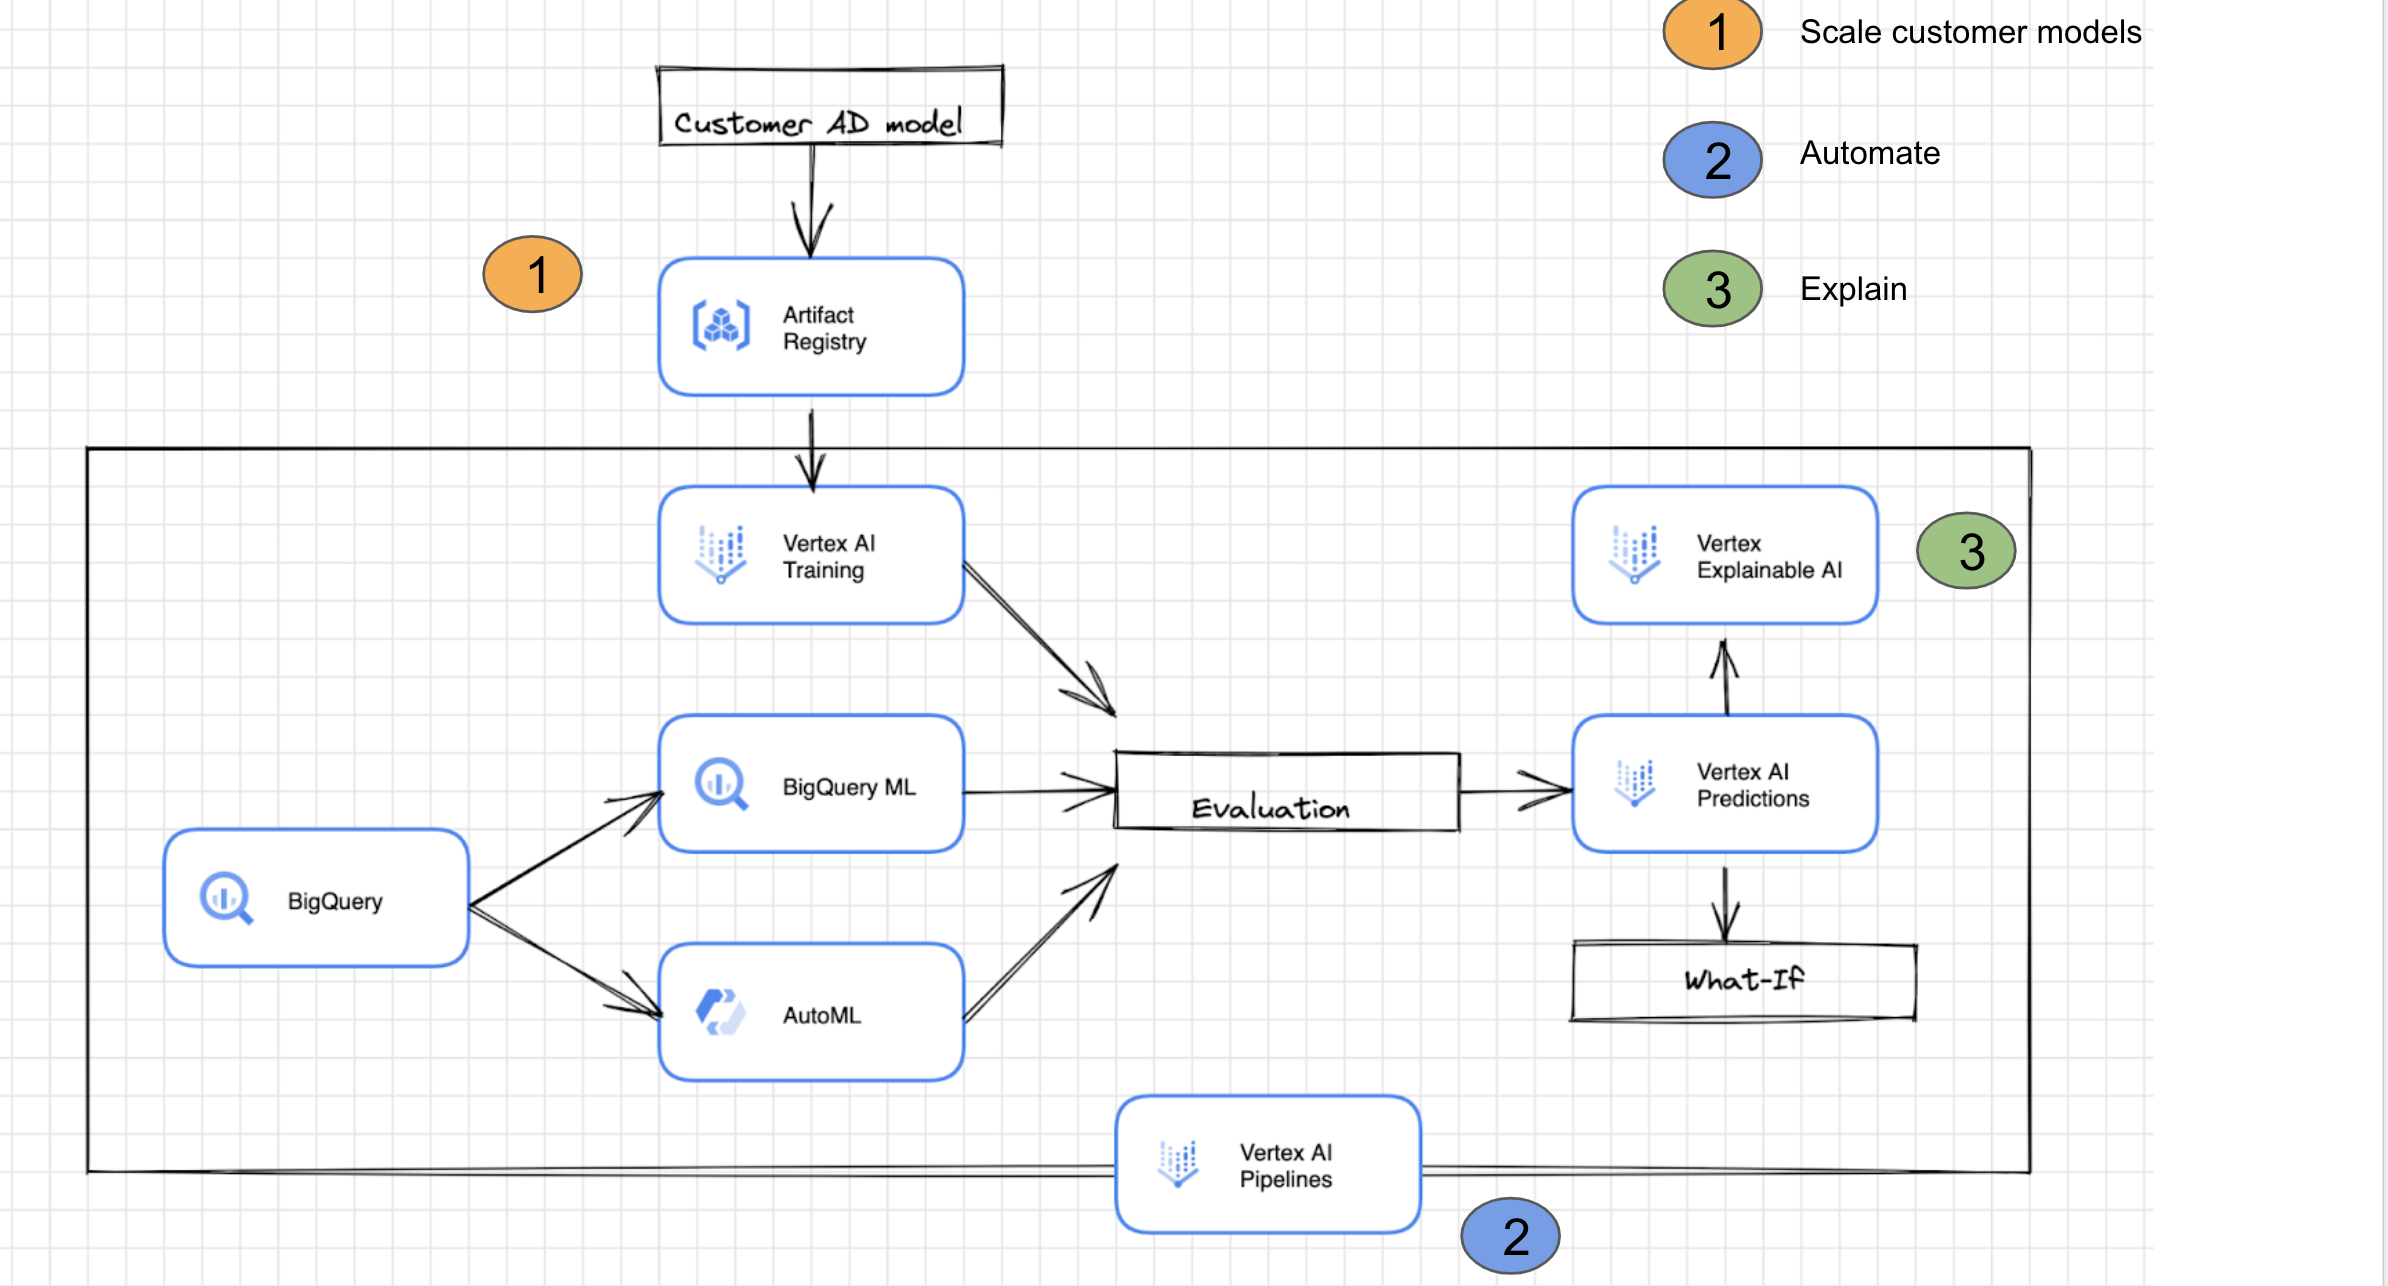

In [ ]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [10]:
# Install Python package dependencies.
print("Installing libraries")
! pip3 install {USER_FLAG} --quiet google-cloud-pipeline-components==1.0.0 kfp
! pip3 install {USER_FLAG} --quiet --upgrade google-cloud-aiplatform google-cloud-bigquery

Installing libraries


In [4]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Required imports

In [ ]:
import sys
import os
from datetime import datetime
from typing import NamedTuple

from google.cloud import aiplatform as vertex
from google_cloud_pipeline_components import \
    aiplatform as vertex_pipeline_components
from google_cloud_pipeline_components.experimental import \
    bigquery as bq_components
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import Artifact, Input, Metrics, Output, component

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [2]:
PROJECT_ID = " "  # @param {type:"string"}

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  experiment-megha


In [3]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "experiment-megha"  # @param {type:"string"}

### Determine some project and pipeline variables

In [19]:
REGION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "demo-anomaly"  # @param {type:"string"}
PIPELINE_JSON_PKG_PATH = "anomaly.json"
PIPELINE_ROOT = f"gs://{BUCKET_NAME}/pipeline_root"
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DATA_FOLDER = f"{BUCKET_NAME}/data"

RAW_INPUT_DATA = f"gs://{DATA_FOLDER}/fraud.csv"
BQ_DATASET = "anomaly"  # @param {type:"string"}
BQ_LOCATION = "US"  # @param {type:"string"}
BQ_LOCATION = BQ_LOCATION.upper()
BQML_EXPORT_LOCATION = f"gs://{BUCKET_NAME}/artifacts/bqml"

DISPLAY_NAME = "anomaly_fraud_pipeline"
ENDPOINT_DISPLAY_NAME = f"{DISPLAY_NAME}_endpoint"

image_prefix = REGION.split("-")[0]
BQML_SERVING_CONTAINER_IMAGE_URI = (
    f"{image_prefix}-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest" #change to xgboost 1.6
)

### Authenticate with GCP

In [5]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

In [6]:
if os.getenv("IS_TESTING"):
    !gcloud --quiet components install beta
    !gcloud --quiet components update
!gcloud config set project $PROJECT_ID
!gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


### Downloading the data

If the bucket does not exist, the script below will create it.

After creating the bucket, the cell below will download the dataset into a CSV file and save it in GCS

In [7]:
! gsutil ls -b gs://{BUCKET_NAME} || gsutil mb -l {REGION} gs://{BUCKET_NAME}

! gsutil cp gs://cloud-samples-data/vertex-ai/managed_notebooks/fraud_detection/fraud_detection_data.csv {RAW_INPUT_DATA}

gs://demo-anomaly/
Copying gs://cloud-samples-data/vertex-ai/managed_notebooks/fraud_detection/fraud_detection_data.csv [Content-Type=application/octet-stream]...
- [1 files][470.7 MiB/470.7 MiB]      0.0 B/s                                   
Operation completed over 1 objects/470.7 MiB.                                    


## Pipeline Components

### Import to BQ

This component takes the csv file and imports it to a table in BigQuery. If the dataset does not exist, it will be created. If a table with the same name already exists, it will be deleted and recreated

In [8]:
@component(base_image="python:3.9", packages_to_install=["google-cloud-bigquery"])
def import_data_to_bigquery(
    project: str,
    bq_location: str,
    bq_dataset: str,
    gcs_data_uri: str,
    raw_dataset: Output[Artifact],
    table_name_prefix: str = "fraud",
):
    from google.cloud import bigquery

    # Construct a BigQuery client object.
    client = bigquery.Client(project=project, location=bq_location)

    def load_dataset(gcs_uri, table_id):
        job_config = bigquery.LoadJobConfig(
            schema=[
                bigquery.SchemaField("Step", "NUMERIC"),
                bigquery.SchemaField("Type", "STRING"),
                bigquery.SchemaField("Amount", "NUMERIC"),
                bigquery.SchemaField("nameOrig", "STRING"),
                bigquery.SchemaField("oldbalanceOrg", "NUMERIC"),
                bigquery.SchemaField("newbalanceOrig", "NUMERIC"),
                bigquery.SchemaField("nameDest", "STRING"),
                bigquery.SchemaField("oldbalanceDest", "NUMERIC"),
                bigquery.SchemaField("newbalanceDest", "NUMERIC"),
                bigquery.SchemaField("isFraud", "NUMERIC"),
                bigquery.SchemaField("isFlaggedFraud", "NUMERIC")
            ],
            skip_leading_rows=1,
            # The source format defaults to CSV, so the line below is optional.
            source_format=bigquery.SourceFormat.CSV,
        )
        print(f"Loading {gcs_uri} into {table_id}")
        load_job = client.load_table_from_uri(
            gcs_uri, table_id, job_config=job_config
        )  # Make an API request.

        load_job.result()  # Waits for the job to complete.
        destination_table = client.get_table(table_id)  # Make an API request.
        print("Loaded {} rows.".format(destination_table.num_rows))

    def create_dataset_if_not_exist(bq_dataset_id, bq_location):
        print(
            "Checking for existence of bq dataset. If it does not exist, it creates one"
        )
        dataset = bigquery.Dataset(bq_dataset_id)
        dataset.location = bq_location
        dataset = client.create_dataset(dataset, exists_ok=True, timeout=300)
        print(f"Created dataset {dataset.full_dataset_id} @ {dataset.location}")

    bq_dataset_id = f"{project}.{bq_dataset}"
    create_dataset_if_not_exist(bq_dataset_id, bq_location)

    raw_table_name = f"{table_name_prefix}_raw"
    table_id = f"{project}.{bq_dataset}.{raw_table_name}"
    print("Deleting any tables that might have the same name on the dataset")
    client.delete_table(table_id, not_found_ok=True)
    print("will load data to table")
    load_dataset(gcs_data_uri, table_id)

    raw_dataset_uri = f"bq://{table_id}"
    raw_dataset.uri = raw_dataset_uri

## Split Datasets

Splits the dataset in 3 slices:
- TRAIN
- EVALUATE
- TEST


AutoML and BigQuery ML use different nomenclatures for data splits:

#### BQML
How BQML splits the data: [link](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#data_split)

#### AutoML
How AutoML splits the data: [link](https://cloud.google.com/vertex-ai/docs/general/ml-use?hl=da&skip_cache=false)

<ul>
    <li>Model trials
<p>The training set is used to train models with different preprocessing, architecture, and hyperparameter option combinations. These models are evaluated on the validation set for quality, which guides the exploration of additional option combinations. The best parameters and architectures determined in the parallel tuning phase are used to train two ensemble models as described below.</p></li>

<li>Model evaluation
<p>
Vertex AI trains an evaluation model, using the training and validation sets as training data. Vertex AI generates the final model evaluation metrics on this model, using the test set. This is the first time in the process that the test set is used. This approach ensures that the final evaluation metrics are an unbiased reflection of how well the final trained model will perform in production.</p></li>

<li>Serving model
<p>A model is trained with the training, validation, and test sets, to maximize the amount of training data. This model is the one that you use to request predictions.</p></li>


In [9]:
@component(
    base_image="python:3.9",
    packages_to_install=["google-cloud-bigquery"],
)  # pandas, pyarrow and fsspec required to export bq data to csv
def split_datasets(
    raw_dataset: Input[Artifact],
    bq_location: str,
) -> NamedTuple(
    "bqml_split",
    [
        ("dataset_uri", str),
        ("dataset_bq_uri", str),
        ("test_dataset_uri", str),
    ],
):

    from collections import namedtuple

    from google.cloud import bigquery

    raw_dataset_uri = raw_dataset.uri
    table_name = raw_dataset_uri.split("bq://")[-1]
    print(table_name)
    raw_dataset_uri = table_name.split(".")
    print(raw_dataset_uri)
    project = raw_dataset_uri[0]
    bq_dataset = raw_dataset_uri[1]
    bq_raw_table = raw_dataset_uri[2]

    client = bigquery.Client(project=project, location=bq_location)

    def split_dataset(table_name_dataset):
        training_dataset_table_name = f"{project}.{bq_dataset}.{table_name_dataset}"
        split_query = f"""
        CREATE OR REPLACE TABLE
            `{training_dataset_table_name}`
           AS
        SELECT
          Step, Type, Amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, isFraud,
            CASE(ABS(MOD(FARM_FINGERPRINT(TO_JSON_STRING(f)), 10)))
              WHEN 9 THEN 'TEST'
              WHEN 8 THEN 'VALIDATE'
              ELSE 'TRAIN' END AS split_col
        FROM
          `{project}.{bq_dataset}.abalone_raw` f
        """
        dataset_uri = f"{project}.{bq_dataset}.{bq_raw_table}"
        print("Splitting the dataset")
        query_job = client.query(split_query)  # Make an API request.
        query_job.result()
        print(dataset_uri)
        print(split_query.replace("\n", " "))
        return training_dataset_table_name

    def create_test_view(training_dataset_table_name, test_view_name="dataset_test"):
        view_uri = f"{project}.{bq_dataset}.{test_view_name}"
        query = f"""
             CREATE OR REPLACE VIEW `{view_uri}` AS SELECT
          Step, Type, Amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, isFraud
          FROM `{training_dataset_table_name}`  f
          WHERE 
          f.split_col = 'TEST'
          """
        print(f"Creating view for --> {test_view_name}")
        print(query.replace("\n", " "))
        query_job = client.query(query)  # Make an API request.
        query_job.result()
        return view_uri

    table_name_dataset = "dataset"

    dataset_uri = split_dataset(table_name_dataset)
    test_dataset_uri = create_test_view(dataset_uri)
    dataset_bq_uri = "bq://" + dataset_uri

    print(f"dataset: {dataset_uri}")

    result_tuple = namedtuple(
        "bqml_split",
        ["dataset_uri", "dataset_bq_uri", "test_dataset_uri"],
    )
    return result_tuple(
        dataset_uri=str(dataset_uri),
        dataset_bq_uri=str(dataset_bq_uri),
        test_dataset_uri=str(test_dataset_uri),
    )

### Train BQML Model

For this demo, we will use a simple linear regression model on BQML. However, you can be creative with other model architectures, such as Deep Neural Networks, XGboost, Logistic Regression, etc.

For a full list of models supported by BQML, look here: [End-to-end user journey for each model](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

As pointed out before, BQML and AutoML use different split terminologies, so we do an adaptation of the <i>split_col</i> column directly on the SELECT portion of the CREATE model query:

> When the value of DATA_SPLIT_METHOD is 'CUSTOM', the corresponding column should be of type BOOL. The rows with TRUE or NULL values are used as evaluation data. Rows with FALSE values are used as training data.


In [10]:
def _query_create_model(
    project_id: str,
    bq_dataset: str,
    training_data_uri: str,
    model_name: str = "linear_regression_model_prototyping",
):
    model_uri = f"{project_id}.{bq_dataset}.{model_name}"

    model_options = """OPTIONS
      ( INPUT_LABEL_COLS=['isFraud'],
        DATA_SPLIT_METHOD='CUSTOM',
        DATA_SPLIT_COL='split_col',
        model_type ='BOOSTED_TREE_CLASSIFIER',
        NUM_PARALLEL_TREE =8,
        MAX_ITERATIONS = 50
        )
        """
    query = f"""
    CREATE OR REPLACE MODEL
      `{model_uri}`
      {model_options}
     AS
    SELECT
      Step, Type, Amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, isFraud,
      CASE(split_col)
        WHEN 'TEST' THEN TRUE
      ELSE
      FALSE
    END
      AS split_col
    FROM
      `{training_data_uri}`;
    """

    print(query.replace("\n", " "))

    return query

### Interpret BQML Model Evaluation

When you do Hyperparameter tuning on the model creation query, the output of the pre-built component [BigqueryEvaluateModelJobOp](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.0/google_cloud_pipeline_components.experimental.bigquery.html#google_cloud_pipeline_components.experimental.bigquery.BigqueryEvaluateModelJobOp) will be a table with the metrics obtained by BQML when training the model. In your BigQuery console, they look like the image below. We need to access them programmatically so we can compare them to the AutoML model. 

<img src="https://storage.googleapis.com/rafacarv-public-bucket-do-not-delete/abalone/bqml-evaluate.png?">

The cell below shows you an example of how this can be done. BQML does not give you a root mean squared error to the list of metrics, so we're manually adding it to the metrics dictionary. For more information aboyt the output, please check [BQML's documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#mlevaluate_output). 

In [11]:
@component(base_image="python:3.9")
def interpret_bqml_evaluation_metrics(
    bqml_evaluation_metrics: Input[Artifact], metrics: Output[Metrics]
) -> dict:
    import math

    metadata = bqml_evaluation_metrics.metadata
    for r in metadata["rows"]:

        rows = r["f"]
        schema = metadata["schema"]["fields"]

        output = {}
        for metric, value in zip(schema, rows):
            metric_name = metric["name"]
            val = float(value["v"])
            output[metric_name] = val
            metrics.log_metric(metric_name, val)

    metrics.log_metric("framework", "BQML")

    print(output)

### Interpret AutoML Model Evaluation

Similar to BQML, AutoML also generates metrics during its model creation. These can be accessed in the UI, as seen below:

<img src="https://storage.googleapis.com/rafacarv-public-bucket-do-not-delete/abalone/automl-evaluate.png" />

Since we don't have a pre-built-component to access these metrics programmatically, we can use the Vertex AI GAPIC (Google API Compiler), which auto-generates low-level gRPC interfaces to the service.


In [12]:
# Inspired by Andrew Ferlitsch's work on https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/ml_ops/stage3/get_started_with_automl_pipeline_components.ipynb


@component(
    base_image="python:3.9",
    packages_to_install=[
        "google-cloud-aiplatform",
    ],
)
def interpret_automl_evaluation_metrics(
    region: str, model: Input[Artifact], metrics: Output[Metrics]
):
    """'
    For a list of available regression metrics, go here: gs://google-cloud-aiplatform/schema/modelevaluation/regression_metrics_1.0.0.yaml.

    More information on available metrics for different types of models: https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-automl
    """

    import google.cloud.aiplatform.gapic as gapic

    # Get a reference to the Model Service client
    client_options = {"api_endpoint": f"{region}-aiplatform.googleapis.com"}

    model_service_client = gapic.ModelServiceClient(client_options=client_options)

    model_resource_name = model.metadata["resourceName"]

    model_evaluations = model_service_client.list_model_evaluations(
        parent=model_resource_name
    )
    model_evaluation = list(model_evaluations)[0]

    available_metrics = [
        "F1 score",
        "Precision",
        "Recall",
    ]
    output = dict()
    for x in available_metrics:
        val = model_evaluation.metrics.get(x)
        output[x] = val
        metrics.log_metric(str(x), float(val))

    metrics.log_metric("framework", "AutoML")
    print(output)

### Model Selection

Now that we have evaluated the models independently, we are going to move forward with only one of them. This election will be done based on the model evaluation metrics gathered in the previous steps.

Bear in mind that BQML and AutoML use different evaluation metric names, hence we had to do a mapping of these different nomenclatures.

In [13]:
@component(base_image="python:3.9")
def select_best_model(
    metrics_bqml: Input[Metrics],
    metrics_automl: Input[Metrics],
    thresholds_dict_str: str,
    best_metrics: Output[Metrics],
    reference_metric_name: str = "rmse",
) -> NamedTuple(
    "Outputs",
    [
        ("deploy_decision", str),
        ("best_model", str),
        ("metric", float),
        ("metric_name", str),
    ],
):
    import json
    from collections import namedtuple

    best_metric = float("inf")
    best_model = None
    metric_bqml = float("inf")
    metric_automl = float("inf")
    print(metrics_bqml.metadata)
    print(metrics_automl.metadata)
    for x in metric_possible_names:

        try:
            metric_bqml = metrics_bqml.metadata[x]
            print(f"Metric bqml: {metric_bqml}")
        except:
            print(f"{x} does not exist int the BQML dictionary")

        try:
            metric_automl = metrics_automl.metadata[x]
            print(f"Metric automl: {metric_automl}")
        except:
            print(f"{x} does not exist on the AutoML dictionary")

    # Change condition if higher is better.
    print(f"Comparing BQML ({metric_bqml}) vs AutoML ({metric_automl})")
    if metric_bqml <= metric_automl:
        best_model = "bqml"
        best_metric = metric_bqml
        best_metrics.metadata = metrics_bqml.metadata
    else:
        best_model = "automl"
        best_metric = metric_automl
        best_metrics.metadata = metrics_automl.metadata

    thresholds_dict = json.loads(thresholds_dict_str)
    deploy = False

    # Change condition if higher is better.
    if best_metric < thresholds_dict[reference_metric_name]:
        deploy = True

    if deploy:
        deploy_decision = "true"
    else:
        deploy_decision = "false"

    print(f"Which model is best? {best_model}")
    print(f"What metric is being used? {reference_metric_name}")
    print(f"What is the best metric? {best_metric}")
    print(f"What is the threshold to deploy? {thresholds_dict_str}")
    print(f"Deploy decision: {deploy_decision}")

    Outputs = namedtuple(
        "Outputs", ["deploy_decision", "best_model", "metric", "metric_name"]
    )

    return Outputs(
        deploy_decision=deploy_decision,
        best_model=best_model,
        metric=best_metric,
        metric_name=reference_metric_name,
    )

### Validate Infrastructure

Once the best model has been deployed, we will validate the endpoint by making a simple prediction to it.

In [17]:
@component(base_image="python:3.9", packages_to_install=["google-cloud-aiplatform"])
def validate_infrastructure(
    endpoint: Input[Artifact],
) -> NamedTuple(
    "validate_infrastructure_output", [("instance", str), ("prediction", float)]
):
    import json
    from collections import namedtuple

    from google.cloud import aiplatform
    from google.protobuf import json_format
    from google.protobuf.struct_pb2 import Value

    def treat_uri(uri):
        return uri[uri.find("projects/") :]

    def request_prediction(endp, instance):
        instance = json_format.ParseDict(instance, Value())
        instances = [instance]
        parameters_dict = {}
        parameters = json_format.ParseDict(parameters_dict, Value())
        response = endp.predict(instances=instances, parameters=parameters)
        print("deployed_model_id:", response.deployed_model_id)
        print("predictions: ", response.predictions)
        # The predictions are a google.protobuf.Value representation of the model's predictions.
        predictions = response.predictions

        for pred in predictions:
            if type(pred) is dict and "value" in pred.keys():
                # AutoML predictions
                prediction = pred["value"]
            elif type(pred) is list:
                # BQML Predictions return different format
                prediction = pred[0]
            return prediction

    endpoint_uri = endpoint.uri
    treated_uri = treat_uri(endpoint_uri)

    instance = {
        "Sex": "M",
        "Length": 0.33,
        "Diameter": 0.255,
        "Height": 0.08,
        "Whole_weight": 0.205,
        "Shucked_weight": 0.0895,
        "Viscera_weight": 0.0395,
        "Shell_weight": 0.055,
    }
    instance_json = json.dumps(instance)
    print("Will use the following instance: " + instance_json)

    endpoint = aiplatform.Endpoint(treated_uri)
    prediction = request_prediction(endpoint, instance)
    result_tuple = namedtuple(
        "validate_infrastructure_output", ["instance", "prediction"]
    )

    return result_tuple(instance=str(instance_json), prediction=float(prediction))

## The Pipeline

In [14]:
pipeline_params = {
    "project": PROJECT_ID,
    "region": REGION,
    "gcs_input_file_uri": RAW_INPUT_DATA,
    "bq_dataset": BQ_DATASET,
    "bq_location": BQ_LOCATION,
    "bqml_model_export_location": BQML_EXPORT_LOCATION,
    "bqml_serving_container_image_uri": BQML_SERVING_CONTAINER_IMAGE_URI,
    "endpoint_display_name": ENDPOINT_DISPLAY_NAME,
    "thresholds_dict_str": '{"rmse": 2.5}',
}

In [17]:
@dsl.pipeline(name=DISPLAY_NAME, description="Rapid Prototyping")
def train_pipeline(
    project: str,
    gcs_input_file_uri: str,
    region: str,
    bq_dataset: str,
    bq_location: str,
    bqml_model_export_location: str,
    bqml_serving_container_image_uri: str,
    endpoint_display_name: str,
    thresholds_dict_str: str,
):
    # Imports data to BigQuery using a custom component.
    import_data_to_bigquery_op = import_data_to_bigquery(
        project, bq_location, bq_dataset, gcs_input_file_uri
    )
    raw_dataset = import_data_to_bigquery_op.outputs["raw_dataset"]

    # Splits the BQ dataset using a custom component.
    split_datasets_op = split_datasets(raw_dataset, bq_location=bq_location)

    # Generates the query to create a BQML using a static function.
    create_model_query = _query_create_model(
        project, bq_dataset, split_datasets_op.outputs["dataset_uri"]
    )

    # Builds BQML model using pre-built-component.
    bqml_create_op = bq_components.BigqueryCreateModelJobOp(
        project=project, location=bq_location, query=create_model_query
    )
    bqml_model = bqml_create_op.outputs["model"]

    # Gathers BQML evaluation metrics using a pre-built-component.
    bqml_evaluate_op = bq_components.BigqueryEvaluateModelJobOp(
        project=project, location=bq_location, model=bqml_model
    )
    bqml_eval_metrics_raw = bqml_evaluate_op.outputs["evaluation_metrics"]

    # Analyzes evaluation BQML metrics using a custom component.
    interpret_bqml_evaluation_metrics_op = interpret_bqml_evaluation_metrics(
        bqml_evaluation_metrics=bqml_eval_metrics_raw
    )
    bqml_eval_metrics = interpret_bqml_evaluation_metrics_op.outputs["metrics"]

    # Exports the BQML model to a GCS bucket using a pre-built-component.
    bqml_export_op = bq_components.BigqueryExportModelJobOp(
        project=project,
        location=bq_location,
        model=bqml_model,
        model_destination_path=bqml_model_export_location,
    ).after(bqml_evaluate_op)
    bqml_exported_gcs_path = bqml_export_op.outputs["exported_model_path"]

    # Uploads the recently exported the BQML model from GCS into Vertex AI using a pre-built-component.
    bqml_model_upload_op = vertex_pipeline_components.ModelUploadOp(
        project=project,
        location=region,
        display_name=DISPLAY_NAME + "_bqml",
        artifact_uri=bqml_exported_gcs_path,
        serving_container_image_uri=bqml_serving_container_image_uri,
    )
    bqml_vertex_model = bqml_model_upload_op.outputs["model"]

    # Creates a Vertex AI Tabular dataset using a pre-built-component.
    dataset_create_op = vertex_pipeline_components.TabularDatasetCreateOp(
        project=project,
        location=region,
        display_name=DISPLAY_NAME,
        bq_source=split_datasets_op.outputs["dataset_bq_uri"],
    )

    # Trains an AutoML Tables model using a pre-built-component.
    automl_training_op = vertex_pipeline_components.AutoMLTabularTrainingJobRunOp(
        project=project,
        location=region,
        display_name=f"{DISPLAY_NAME}_automl",
        optimization_prediction_type="classification",
        predefined_split_column_name="split_col",
        dataset=dataset_create_op.outputs["dataset"],
        target_column="isFraud",
        column_transformations=[
            {"categorical": {"column_name": "Type"}},
            {"numeric": {"column_name": "Step"}},
            {"numeric": {"column_name": "Amount"}},
            {"numeric": {"column_name": "oldbalanceOrg"}},
            {"numeric": {"column_name": "newbalanceOrig"}},
            {"numeric": {"column_name": "oldbalanceDest"}},
            {"numeric": {"column_name": "newbalanceDest"}},
        ],
    )
    automl_model = automl_training_op.outputs["model"]

    # Analyzes evaluation AutoML metrics using a custom component.
    automl_eval_op = interpret_automl_evaluation_metrics(
        region=region, model=automl_model
    )
    automl_eval_metrics = automl_eval_op.outputs["metrics"]

    # 1) Decides which model is best (AutoML vs BQML);
    # 2) Determines if the best model meets the deployment condition.
    best_model_task = select_best_model(
        metrics_bqml=bqml_eval_metrics,
        metrics_automl=automl_eval_metrics,
        thresholds_dict_str=thresholds_dict_str,
    )

    # If the deploy condition is True, then deploy the best model.
    with dsl.Condition(
        best_model_task.outputs["deploy_decision"] == "true",
        name="deploy_decision",
    ):
        # Creates a Vertex AI endpoint using a pre-built-component.
        endpoint_create_op = vertex_pipeline_components.EndpointCreateOp(
            project=project,
            location=region,
            display_name=endpoint_display_name,
        )
        endpoint_create_op.after(best_model_task)

        # In case the BQML model is the best...
        with dsl.Condition(
            best_model_task.outputs["best_model"] == "bqml",
            name="deploy_bqml",
        ):
            # Deploys the BQML model (now on Vertex AI) to the recently created endpoint using a pre-built component.
            model_deploy_bqml_op = (
                vertex_pipeline_components.ModelDeployOp(  # noqa: F841
                    endpoint=endpoint_create_op.outputs["endpoint"],
                    model=bqml_vertex_model,
                    deployed_model_display_name=DISPLAY_NAME + "_best_bqml",
                    dedicated_resources_machine_type="n1-standard-2",
                    dedicated_resources_min_replica_count=2,
                    dedicated_resources_max_replica_count=2,
                    traffic_split={
                        "0": 100
                    },  # newly deployed model gets 100% of the traffic
                ).set_caching_options(False)
            )

            # Sends an online prediction request to the recently deployed model using a custom component.
         #   validate_infrastructure(
          #      endpoint=endpoint_create_op.outputs["endpoint"]
          #  ).set_caching_options(False).after(model_deploy_bqml_op)

        # In case the AutoML model is the best...
        with dsl.Condition(
            best_model_task.outputs["best_model"] == "automl",
            name="deploy_automl",
        ):
            # Deploys the AutoML model to the recently created endpoint using a pre-built component.
            model_deploy_automl_op = (
                vertex_pipeline_components.ModelDeployOp(  # noqa: F841
                    endpoint=endpoint_create_op.outputs["endpoint"],
                    model=automl_model,
                    deployed_model_display_name=DISPLAY_NAME + "_best_automl",
                    dedicated_resources_machine_type="n1-standard-2",
                    dedicated_resources_min_replica_count=2,
                    dedicated_resources_max_replica_count=2,
                    traffic_split={
                        "0": 100
                    },  # newly deployed model gets 100% of the traffic
                ).set_caching_options(False)
            )

            # Sends an online prediction request to the recently deployed model using a custom component.
         #   validate_infrastructure(
           #     endpoint=endpoint_create_op.outputs["endpoint"]
           # ).set_caching_options(False).after(model_deploy_automl_op)

### Running the Pipeline

In [20]:
compiler.Compiler().compile(
    pipeline_func=train_pipeline,
    package_path=PIPELINE_JSON_PKG_PATH,
)


vertex.init(project=PROJECT_ID, location=REGION)

pipeline_job = vertex.PipelineJob(
    display_name=DISPLAY_NAME,
    template_path=PIPELINE_JSON_PKG_PATH,
    pipeline_root=PIPELINE_ROOT,
    parameter_values=pipeline_params,
    enable_caching=True,
)

response = pipeline_job.submit()

     CREATE OR REPLACE MODEL       `{{pipelineparam:op=;name=project}}.{{pipelineparam:op=;name=bq_dataset}}.linear_regression_model_prototyping`       OPTIONS       ( INPUT_LABEL_COLS=['isFraud'],         DATA_SPLIT_METHOD='CUSTOM',         DATA_SPLIT_COL='split_col',         model_type ='BOOSTED_TREE_CLASSIFIER',         NUM_PARALLEL_TREE =8,         MAX_ITERATIONS = 50         )               AS     SELECT       Step, Type, Amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, isFraud,       CASE(split_col)         WHEN 'TEST' THEN TRUE       ELSE       FALSE     END       AS split_col     FROM       `{{pipelineparam:op=split-datasets;name=dataset_uri}}`;     
INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/29437252490/locations/us-central1/pipelineJobs/rapid-prototyping-20220315174506
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another s

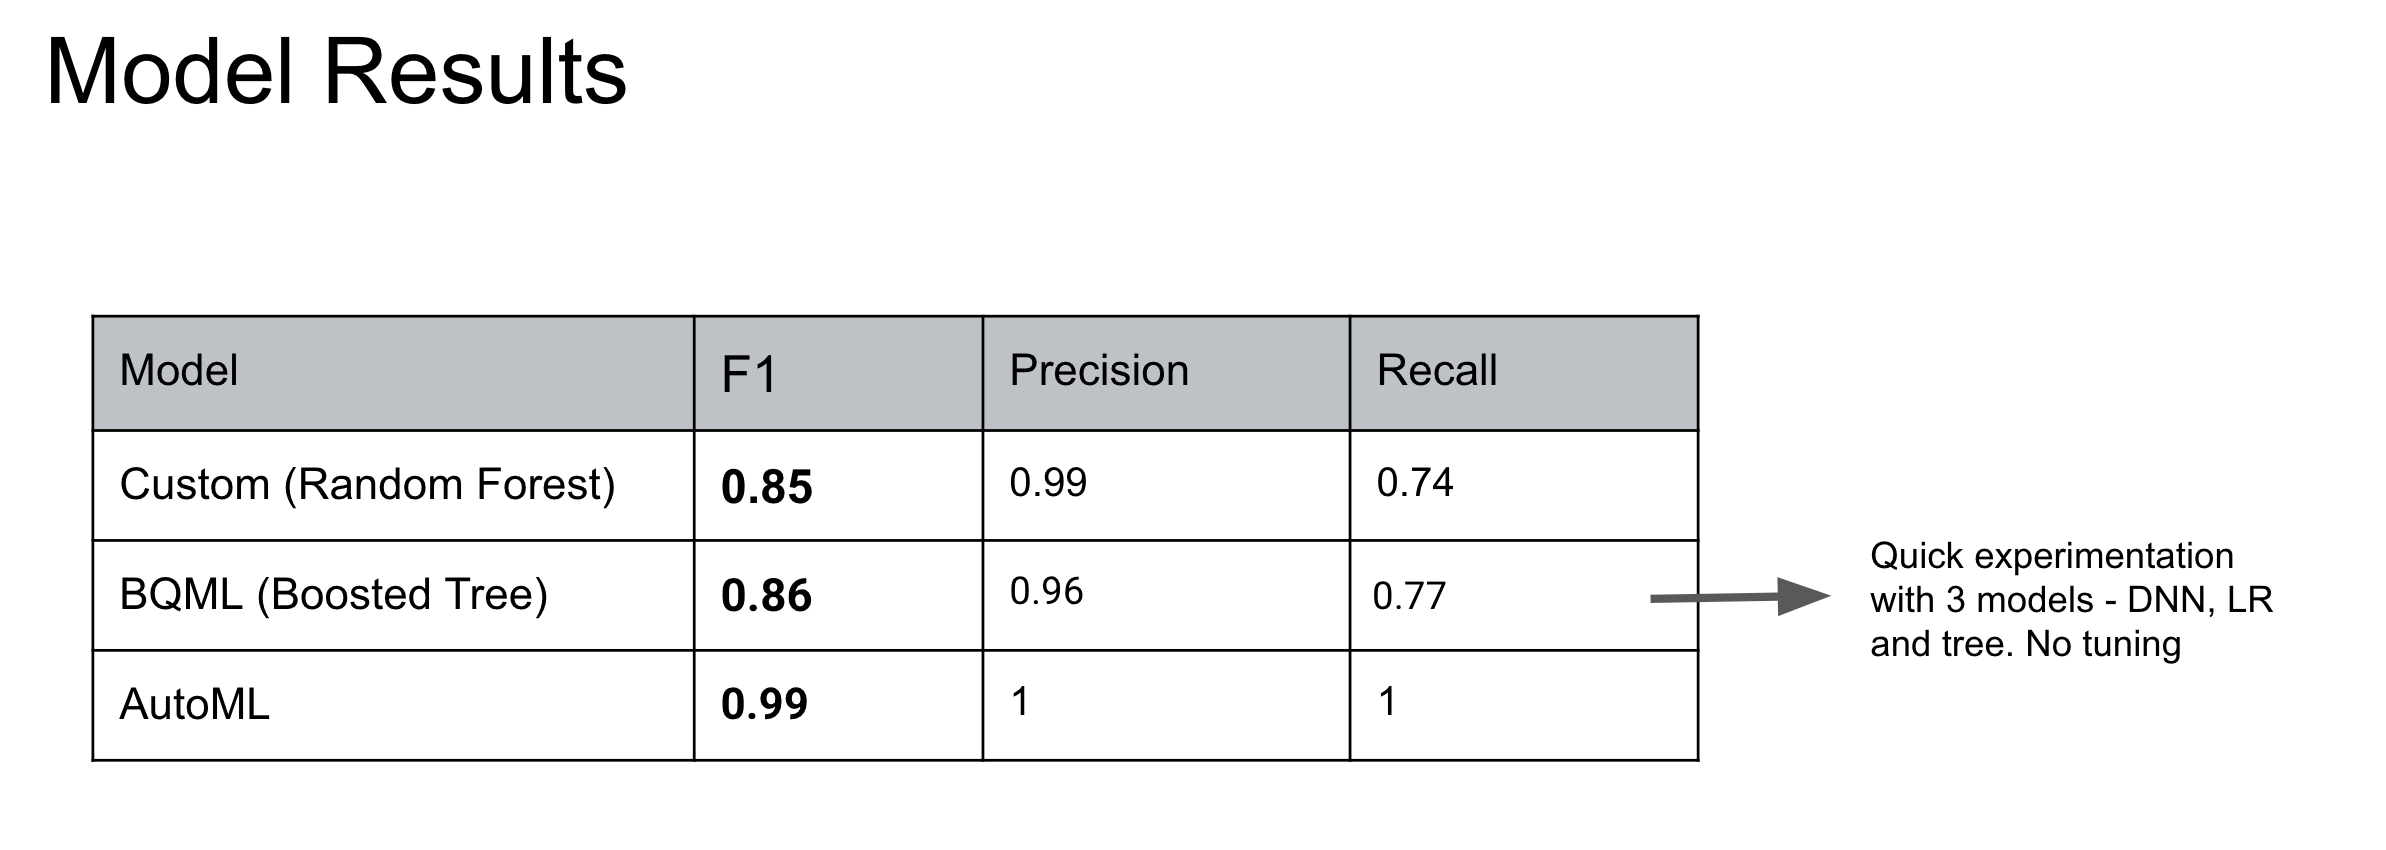

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [22]:
vertex.init(project=PROJECT_ID, location=REGION)

delete = False  # set to True if you want to delete resources


delete_vertex_dataset = True and delete
delete_pipeline = True and delete
delete_model = True and delete
delete_endpoint = True and delete
delete_batchjob = True and delete
delete_bucket = True and delete
delete_bq_dataset = True and delete

try:
    if delete_endpoint and "DISPLAY_NAME" in globals():
        print("Will delete endpoint")
        endpoints = vertex.Endpoint.list(
            filter=f"display_name={DISPLAY_NAME}_endpoint", order_by="create_time"
        )
        endpoint = endpoints[0]
        endpoint.undeploy_all()
        vertex.Endpoint.delete(endpoint.resource_name)
        print("Deleted endpoint:", endpoint)
except Exception as e:
    print(e)

if delete_model and "DISPLAY_NAME" in globals():
    print("Will delete models")
    suffix_list = ["bqml", "automl", "best"]
    for suffix in suffix_list:
        try:
            model_display_name = f"{DISPLAY_NAME}_{suffix}"
            print("Will delete model with name " + model_display_name)
            models = vertex.Model.list(
                filter=f"display_name={model_display_name}", order_by="create_time"
            )

            model = models[0]
            vertex.Model.delete(model)
            print("Deleted model:", model)
        except Exception as e:
            print(e)

if delete_vertex_dataset and "DISPLAY_NAME" in globals():
    print("Will delete Vertex dataset")
    try:
        datasets = vertex.TabularDataset.list(
            filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
        )

        dataset = datasets[0]
        vertex.TabularDataset.delete(dataset)
        print("Deleted Vertex dataset:", dataset)
    except Exception as e:
        print(e)


try:
    if delete_pipeline and "DISPLAY_NAME" in globals():
        pipelines = vertex.PipelineJob.list(
            filter=f"pipeline_name={DISPLAY_NAME}", order_by="create_time"
        )
        pipeline = pipelines[0]
        vertex.PipelineJob.delete(pipeline)
        print("Deleted pipeline:", pipeline)
except Exception as e:
    print(e)

if delete_bq_dataset and "DISPLAY_NAME" in globals():
    from google.cloud import bigquery

    try:
        # Construct a BigQuery client object.

        bq_client = bigquery.Client(project=PROJECT_ID, location=BQ_LOCATION)

        # TODO(developer): Set model_id to the ID of the model to fetch.
        dataset_id = f"{PROJECT_ID}.{BQ_DATASET}"

        print(f"Will delete BQ dataset '{dataset_id}' from location {BQ_LOCATION}.")
        # Use the delete_contents parameter to delete a dataset and its contents.
        # Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
        bq_client.delete_dataset(
            dataset_id, delete_contents=True, not_found_ok=True
        )  # Make an API request.

        print(f"Deleted BQ dataset '{dataset_id}' from location {BQ_LOCATION}.")
    except Exception as e:
        print(e)


if delete_bucket and "BUCKET_NAME" in globals():
    ! gsutil rm -r gs://$BUCKET_NAME